<h1 style="text-align: center;">Lab 1</h1>
<h4 style="text-align: center;"><span style="text-decoration: underline">Submitted by :</span> BOULBEN Firdaous</h4>
<h4 style="text-align: center;"><span style="text-decoration: underline">Supervised by
:</span> Pr. EL AACHAK Lotfi</h4>  

## Objective : 
The main purpose behind this lab is to get familiar with Pytorch library to do
Classification and Regression tasks by establishing DNN/MLP architectures.

## Part one: Regression

In [6]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

In [7]:
# Load the datasets
prices = pd.read_csv("/kaggle/input/nyse/prices.csv")
securities = pd.read_csv("/kaggle/input/nyse/securities.csv")
fundamentals = pd.read_csv("/kaggle/input/nyse/fundamentals.csv")
prices_split_adjusted = pd.read_csv("/kaggle/input/nyse/prices-split-adjusted.csv")

In [3]:
# Display Data Head
print("Prices Dataset Head:\n", prices.head())
print("Securities Dataset Head:\n", securities.head())
print("Fundamentals Dataset Head:\n", fundamentals.head())
print("Prices Split Adjusted Dataset Head:\n", prices_split_adjusted.head())

Prices Dataset Head:
                   date symbol        open       close         low        high  \
0  2016-01-05 00:00:00   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06 00:00:00   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07 00:00:00   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08 00:00:00   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11 00:00:00   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0  
Securities Dataset Head:
   Ticker symbol             Security SEC filings             GICS Sector  \
0           MMM           3M Company     reports             Industrials   
1           ABT  Abbott Laboratories     reports             Health Care   
2          ABBV               AbbVie     reports             Health Care   
3           ACN        Accenture plc     reports  Information Technolog

In [8]:
# Quick data summary to understand data structure and check for null values
print(prices.info())
print(securities.info())
print(fundamentals.info())
print(prices_split_adjusted.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Ticker symbol            505 non-null    object
 1   Security                 505 non-null    object
 2   SEC filings              505 non-null    object
 3   GICS Sector              505 non-null    object
 4   GICS Sub Industry        505 non-null    object
 5   Address of

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


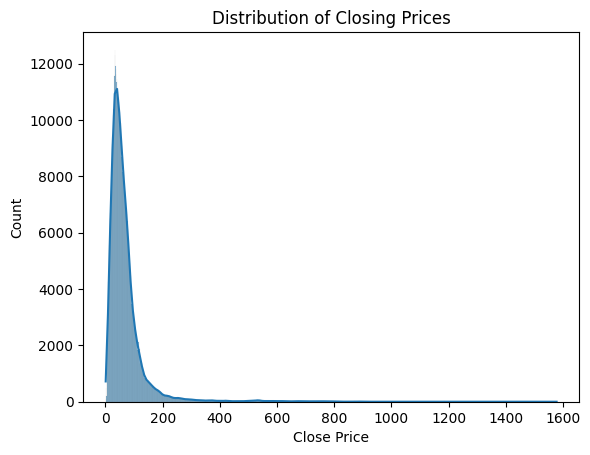

In [9]:
# Visualize key data distributions and correlations for EDA
sns.histplot(prices['close'], kde=True)
plt.title('Distribution of Closing Prices')
plt.xlabel('Close Price')
plt.show()

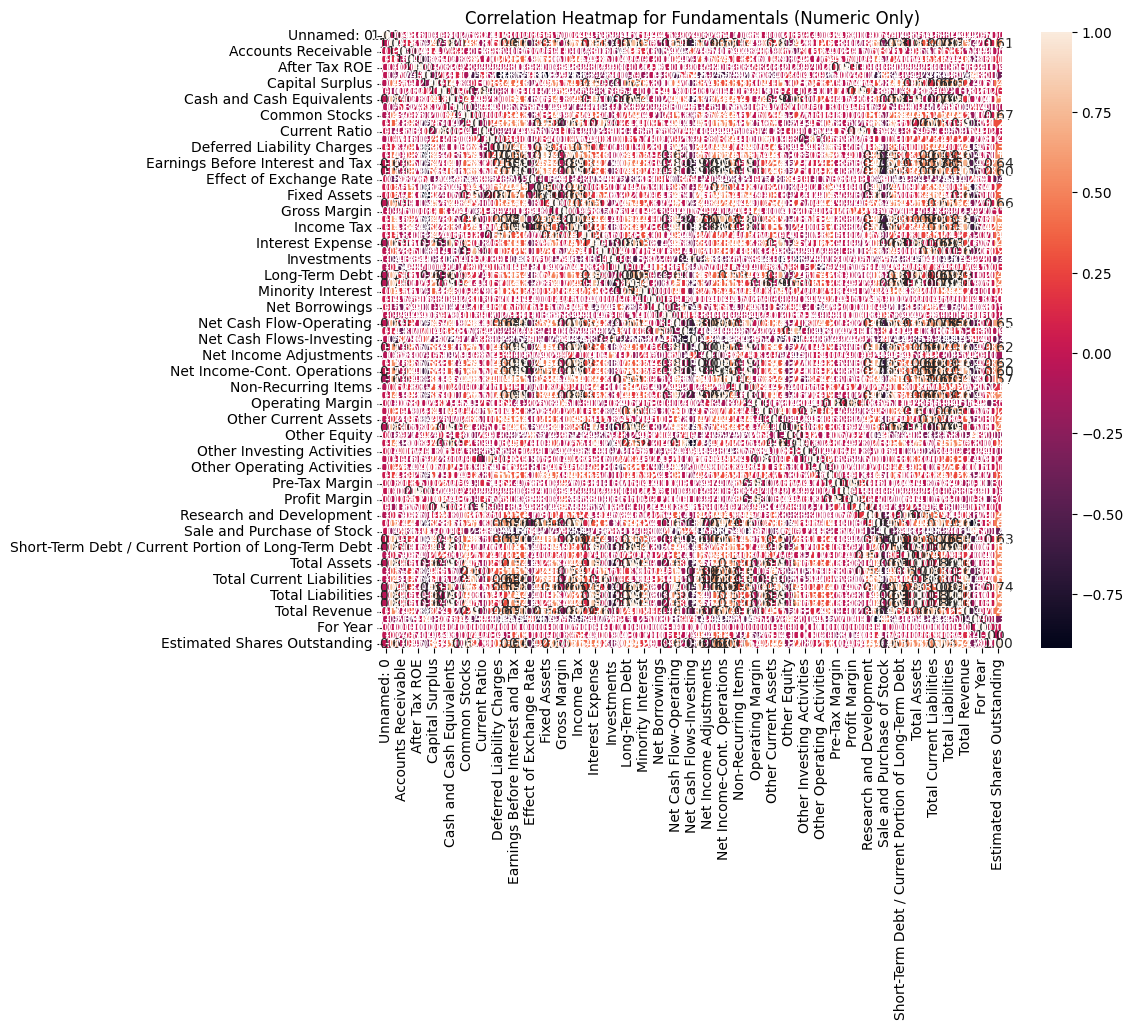

In [11]:
numeric_fundamentals = fundamentals.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_fundamentals.corr(), annot=True, fmt='.2f')
plt.title('Correlation Heatmap for Fundamentals (Numeric Only)')
plt.show()

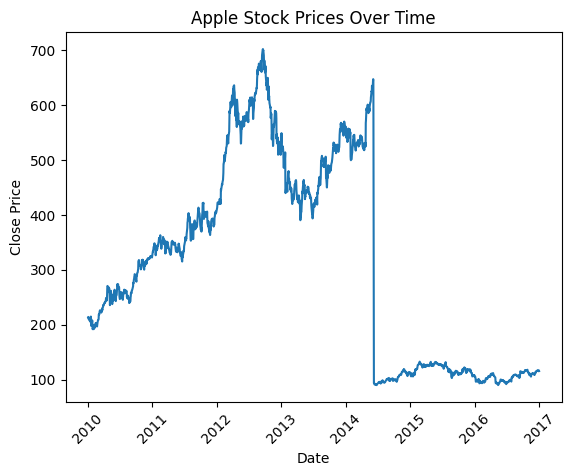

In [12]:
# Example of time-series visualization for a specific stock
sample_stock = prices[prices['symbol'] == 'AAPL']  # Select a sample stock, e.g., Apple
plt.plot(pd.to_datetime(sample_stock['date']), sample_stock['close'])
plt.title('Apple Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.show()

In [13]:
# Selecting 'close' as target variable and removing columns that are non-numeric or irrelevant
features = prices.drop(columns=['date', 'symbol', 'close'])
targets = prices['close']

In [14]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

In [15]:
# Scaling features for better model performance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
# Define custom dataset class for PyTorch
class NYSEDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets.values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

In [17]:
# Create PyTorch dataloaders
train_dataset = NYSEDataset(X_train, y_train)
test_dataset = NYSEDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [18]:
# Define the regression model
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        return self.output(x)

In [19]:
# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
model = RegressionModel(input_dim=input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# Training the model
num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_losses.append(train_loss / len(train_loader))

    # Validation phase
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()
    
    test_losses.append(test_loss / len(test_loader))
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

Epoch [1/100], Train Loss: 110.0082, Test Loss: 1.2636
Epoch [2/100], Train Loss: 1.7866, Test Loss: 1.9149
Epoch [3/100], Train Loss: 1.6078, Test Loss: 0.8003
Epoch [4/100], Train Loss: 1.3357, Test Loss: 0.5809
Epoch [5/100], Train Loss: 1.3121, Test Loss: 1.3315
Epoch [6/100], Train Loss: 1.1422, Test Loss: 1.8326
Epoch [7/100], Train Loss: 1.1845, Test Loss: 1.1683
Epoch [8/100], Train Loss: 1.1160, Test Loss: 3.7670
Epoch [9/100], Train Loss: 1.1143, Test Loss: 0.9018
Epoch [10/100], Train Loss: 1.0617, Test Loss: 0.5978
Epoch [11/100], Train Loss: 0.9687, Test Loss: 0.4581
Epoch [12/100], Train Loss: 0.9721, Test Loss: 1.2957
Epoch [13/100], Train Loss: 1.0473, Test Loss: 0.8814
Epoch [14/100], Train Loss: 0.9258, Test Loss: 1.3736
Epoch [15/100], Train Loss: 0.9479, Test Loss: 0.6750
Epoch [16/100], Train Loss: 0.9456, Test Loss: 1.1670
Epoch [17/100], Train Loss: 0.8749, Test Loss: 0.4331
Epoch [18/100], Train Loss: 0.9630, Test Loss: 0.9981
Epoch [19/100], Train Loss: 0.9910,

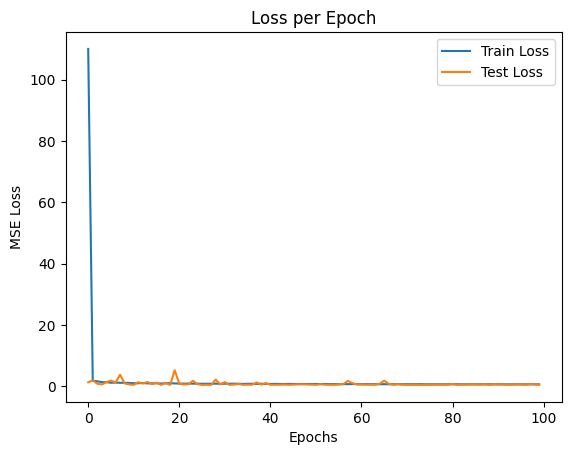

In [21]:
# Plotting loss per epoch
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Loss per Epoch')
plt.show()

In [22]:
# Example of manual grid search for hyperparameters
# Different configurations to try for learning rates and layers
learning_rates = [0.001, 0.01]
batch_sizes = [64, 128]
epochs_list = [50, 100]

In [23]:
# Loop through each combination of hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        for num_epochs in epochs_list:
            model = RegressionModel(input_dim=input_dim)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            # Create new dataloader with adjusted batch size
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            
            # Training loop (similar to above), store best configuration based on validation loss

In [24]:
# Define a regularized version of the model using dropout
class RegularizedRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegularizedRegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.layer2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.layer3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.dropout1(self.layer1(x)))
        x = torch.relu(self.dropout2(self.layer2(x)))
        x = torch.relu(self.layer3(x))
        return self.output(x)

In [25]:
# Initialize and retrain the model with regularization
regularized_model = RegularizedRegressionModel(input_dim=input_dim)
optimizer = optim.Adam(regularized_model.parameters(), lr=0.001)

In [26]:
# Retrain the model as in Part 4, but using the regularized model and plotting results for comparison
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    regularized_model.train()  # Set model to training mode
    train_loss = 0
    
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = regularized_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_losses.append(train_loss / len(train_loader))

    # Validation phase
    regularized_model.eval()  # Set model to evaluation mode
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = regularized_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()
    
    test_losses.append(test_loss / len(test_loader))
    
    print(f"Regularized Model - Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")



Regularized Model - Epoch [1/100], Train Loss: 341.0896, Test Loss: 49.5390
Regularized Model - Epoch [2/100], Train Loss: 134.0175, Test Loss: 114.0517
Regularized Model - Epoch [3/100], Train Loss: 110.4584, Test Loss: 71.3829
Regularized Model - Epoch [4/100], Train Loss: 86.2113, Test Loss: 156.6887
Regularized Model - Epoch [5/100], Train Loss: 61.5212, Test Loss: 360.8632
Regularized Model - Epoch [6/100], Train Loss: 52.3407, Test Loss: 374.2909
Regularized Model - Epoch [7/100], Train Loss: 48.5757, Test Loss: 560.3711
Regularized Model - Epoch [8/100], Train Loss: 46.8827, Test Loss: 632.6072
Regularized Model - Epoch [9/100], Train Loss: 43.1129, Test Loss: 740.3546
Regularized Model - Epoch [10/100], Train Loss: 43.1406, Test Loss: 504.5119
Regularized Model - Epoch [11/100], Train Loss: 40.6146, Test Loss: 487.9379
Regularized Model - Epoch [12/100], Train Loss: 41.5682, Test Loss: 634.3213
Regularized Model - Epoch [13/100], Train Loss: 37.6033, Test Loss: 647.4209
Regular

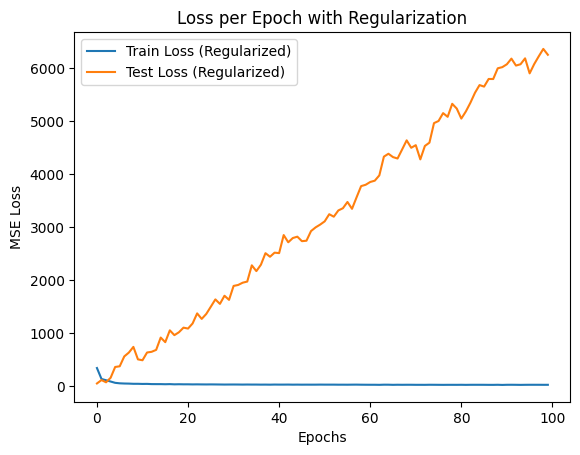

In [27]:
# Plotting loss per epoch for the regularized model
plt.plot(range(num_epochs), train_losses, label='Train Loss (Regularized)')
plt.plot(range(num_epochs), test_losses, label='Test Loss (Regularized)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Loss per Epoch with Regularization')
plt.show()

## Part two: Multi Class Classification

In [30]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### 1. Apply the per-processing technics and the given dataset to clean, standardization/normalization of the data. 

In [31]:
# Load and Inspect the Data
data = pd.read_csv("/kaggle/input/machine-predictive-maintenance-classification/predictive_maintenance.csv")

In [32]:
# Check the first few rows to verify data loading
print(data.head())

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  


In [33]:
# Display basic information and first few rows
print("Dataset Info:")
print(data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
None


In [34]:
# Display summary statistics for the data
print("\n Dataset Summary:")
print(data.describe())


 Dataset Summary:
               UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]        Target  
count            10000.000000  10000.000000     10000.000000  10000.000000  
mean              1538.776100     39.986910       107.951000      0.033900  
std                179.284096      9.968934        63.654147      0.180981  
min               1168.000000      3.800000         0.000000

In [35]:
print(data.columns)

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')


In [36]:
# Explore and clean data
data = data.drop(columns=['UDI', 'Product ID'])

In [37]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [38]:
# Check unique values in categorical columns
print("Unique values in 'Type':", data['Type'].unique())
print("Unique values in 'Failure Type':", data['Failure Type'].unique())

Unique values in 'Type': ['M' 'L' 'H']
Unique values in 'Failure Type': ['No Failure' 'Power Failure' 'Tool Wear Failure' 'Overstrain Failure'
 'Random Failures' 'Heat Dissipation Failure']


In [39]:
# Remove duplicates
data = data.drop_duplicates()

In [40]:
# Standardize/Normalize Numerical Data

# Select numerical columns
numerical_cols = ['Air temperature [K]', 'Process temperature [K]', 
                  'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Initialize the standard scaler
scaler = StandardScaler()

# Apply standardization to numerical columns
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

In [41]:
# Separate features (X) and target (y)
X = data.drop(columns=['Target'])
y = data['Target']

In [42]:
# Check the cleaned data
print(X.info())
print(X.head())
print("Target values:", y.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     10000 non-null  object 
 1   Air temperature [K]      10000 non-null  float64
 2   Process temperature [K]  10000 non-null  float64
 3   Rotational speed [rpm]   10000 non-null  float64
 4   Torque [Nm]              10000 non-null  float64
 5   Tool wear [min]          10000 non-null  float64
 6   Failure Type             10000 non-null  object 
dtypes: float64(5), object(2)
memory usage: 547.0+ KB
None
  Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M            -0.952389                -0.947360                0.068185   
1    L            -0.902393                -0.879959               -0.729472   
2    L            -0.952389                -1.014761               -0.227450   
3    L            -0.902393 

###  2. Apply the Exploratory data analysis technics to understand and visualize the given Dataset.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

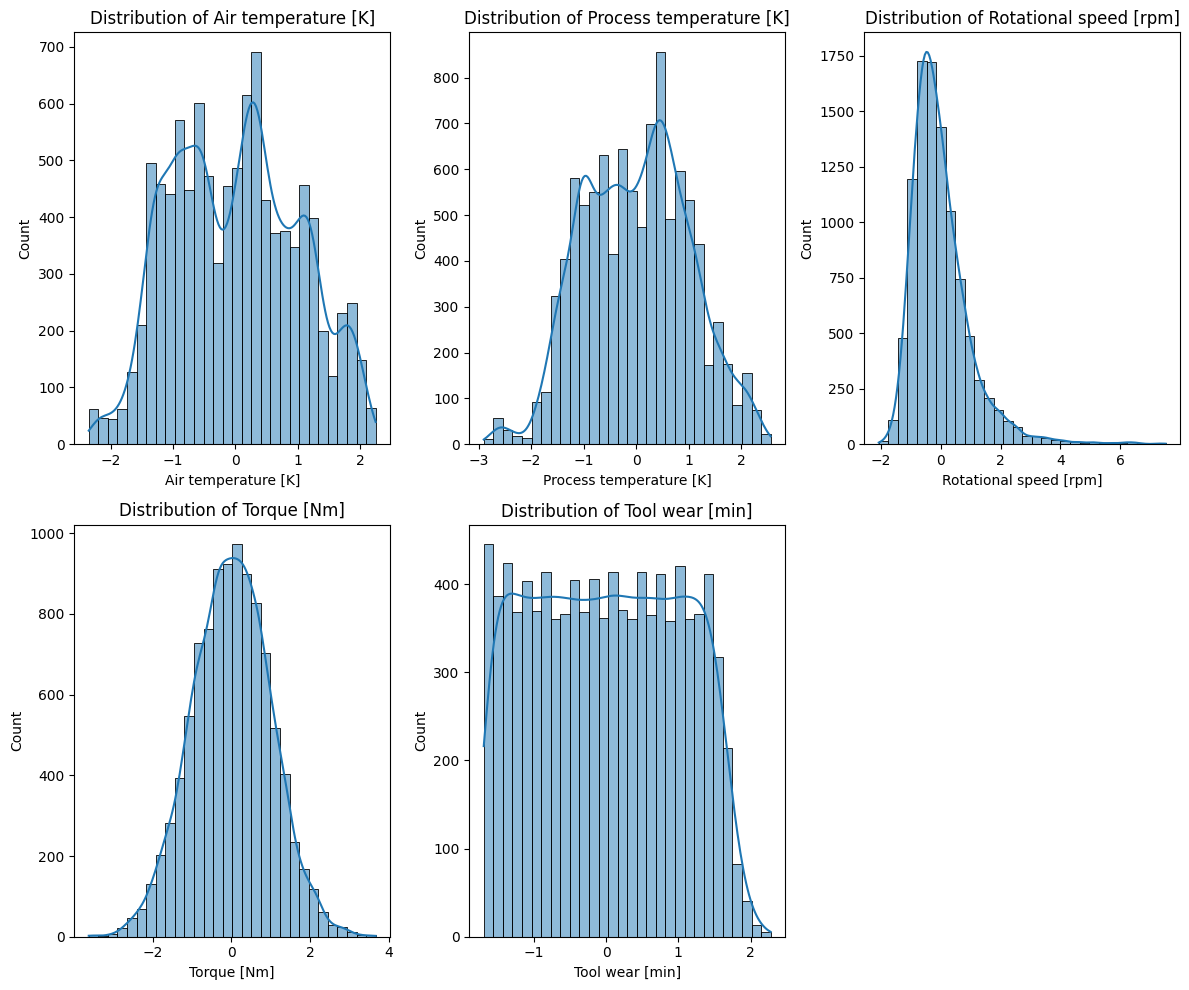

In [43]:
# Understand the Distribution of Numerical Features

# Plot histograms of numerical features
numerical_cols = ['Air temperature [K]', 'Process temperature [K]', 
                  'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Loop through numerical columns to plot histograms
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(X[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

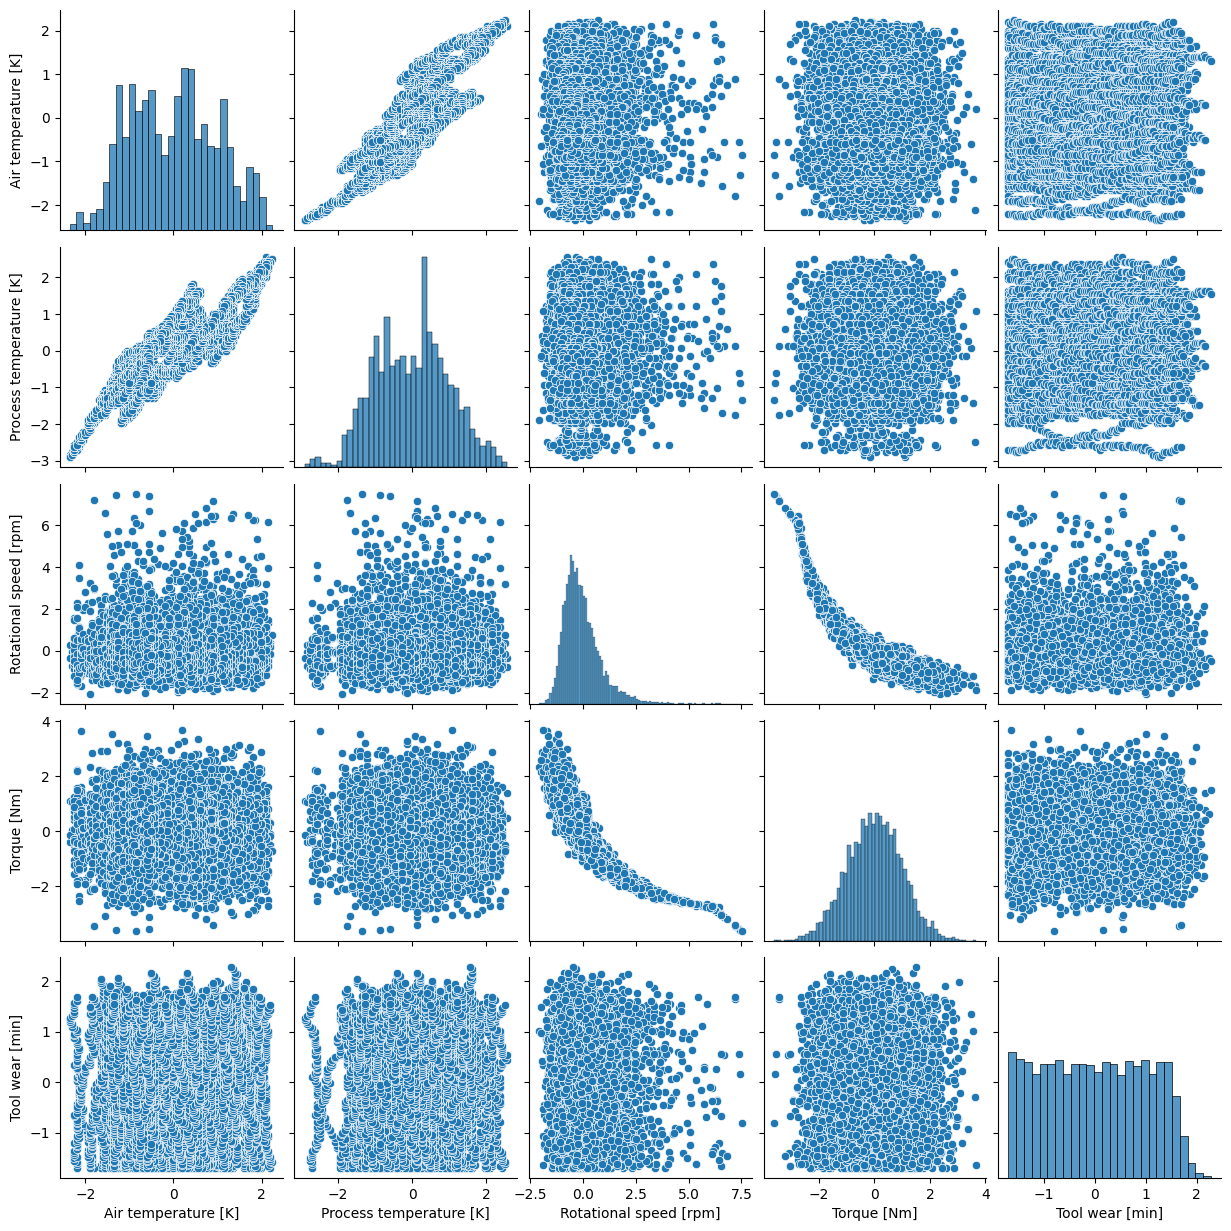

In [44]:
# Visualizing pairwise relationships between numerical columns
sns.pairplot(X[numerical_cols])
plt.show()

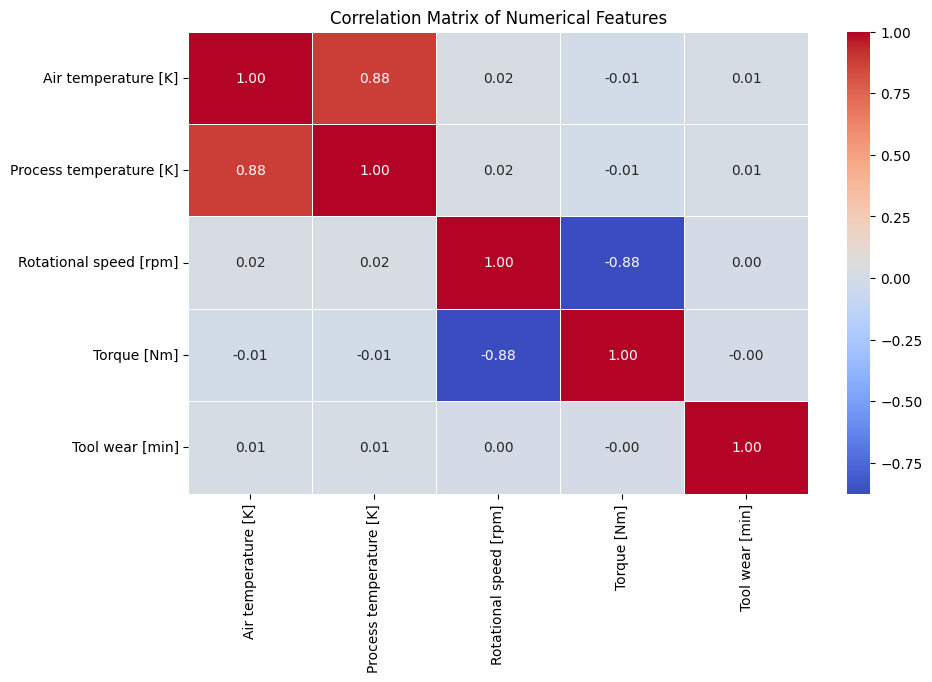

In [45]:
# Compute correlation matrix
correlation_matrix = X[numerical_cols].corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

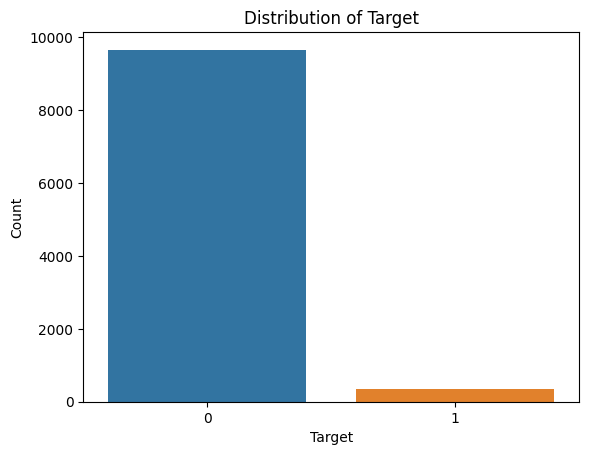

In [46]:
# Plot the distribution of the target variable
sns.countplot(x=y)
plt.title('Distribution of Target')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

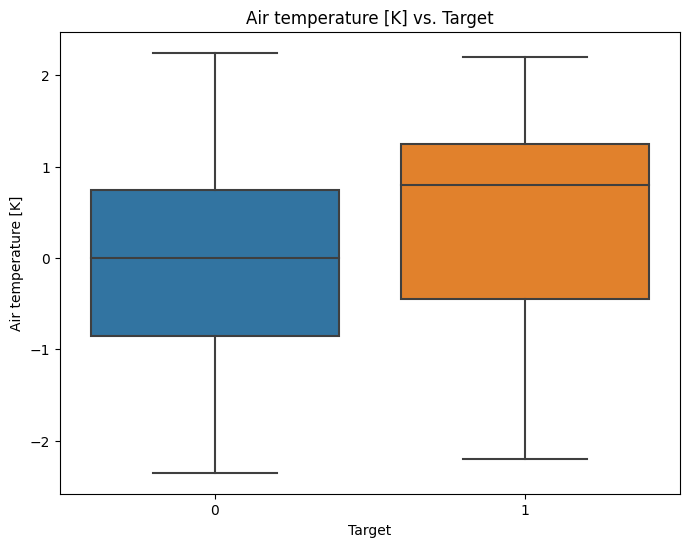

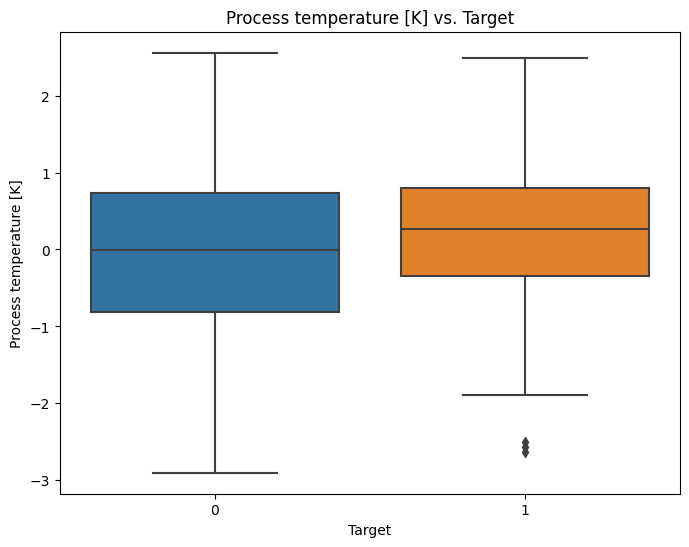

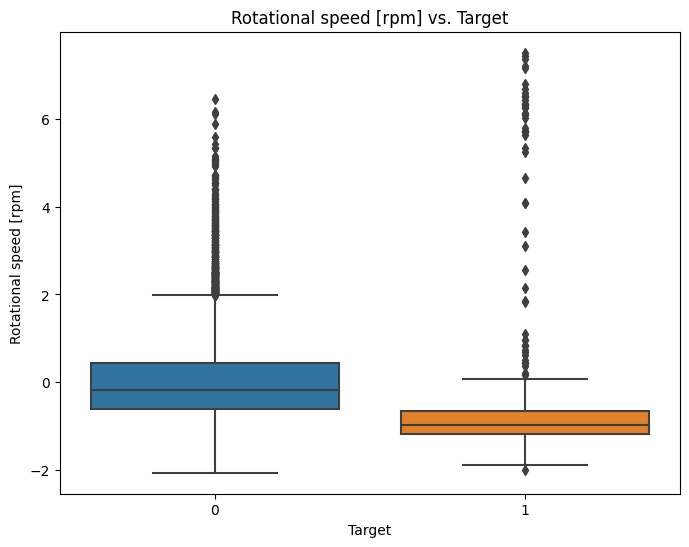

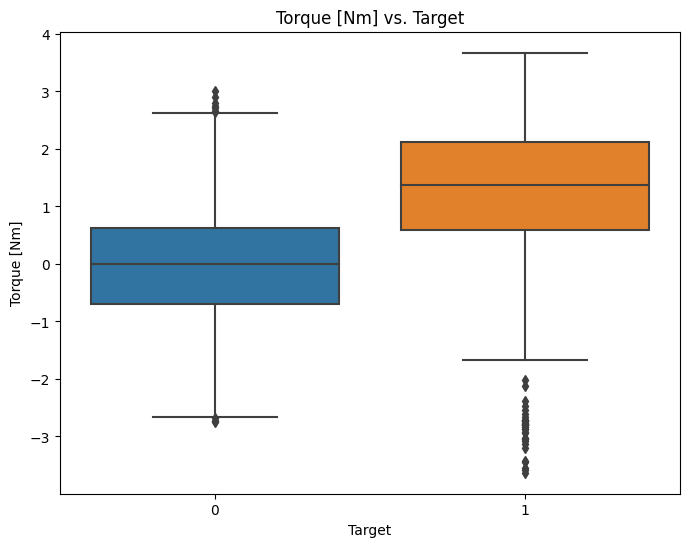

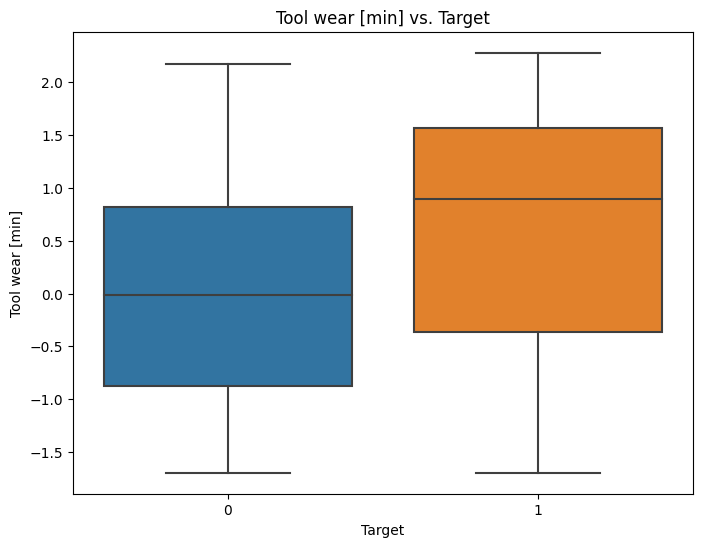

In [47]:
# Plot distribution of numerical features grouped by Target
for col in numerical_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=y, y=X[col])
    plt.title(f'{col} vs. Target')
    plt.show()

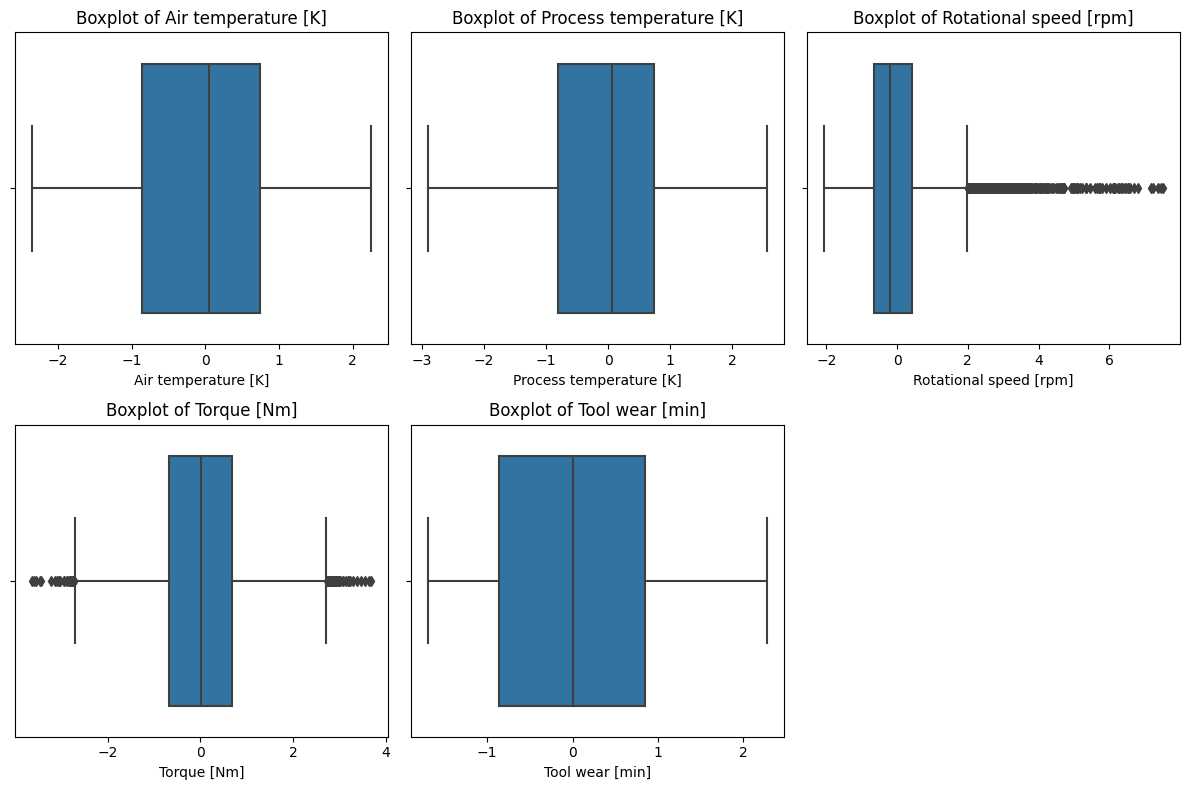

In [48]:
# Boxplot for detecting outliers in numerical features
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=X[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

### 3. Apply data augmentation technics to balance the given Dataset.  

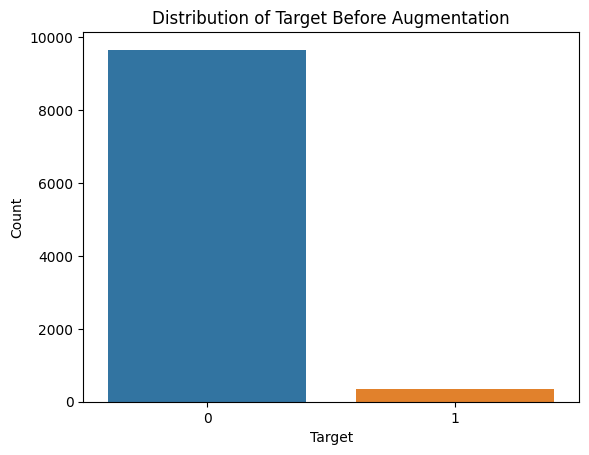

Target
0    9661
1     339
Name: count, dtype: int64


In [50]:
# Check the distribution of the target variable
sns.countplot(x=y)
plt.title('Distribution of Target Before Augmentation')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Count the number of samples in each class
print(y.value_counts())

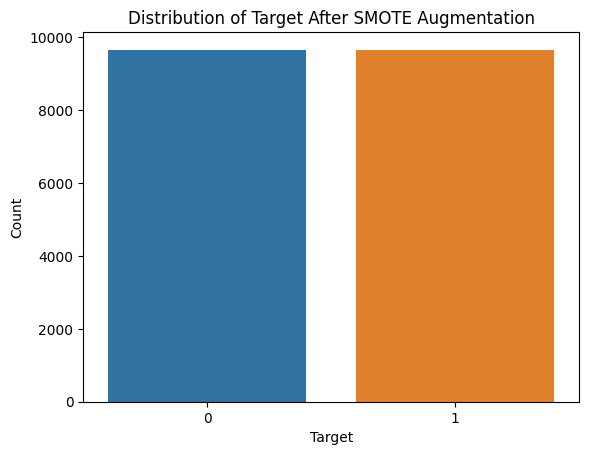

Target
0    9661
1    9661
Name: count, dtype: int64


In [52]:
# Apply Oversampling Using SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to balance the dataset
X_numerical = X[numerical_cols]
X_resampled, y_resampled = smote.fit_resample(X_numerical, y)

# Check the new distribution of the target variable
sns.countplot(x=y_resampled)
plt.title('Distribution of Target After SMOTE Augmentation')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Count the number of samples in each class after SMOTE
print(y_resampled.value_counts())

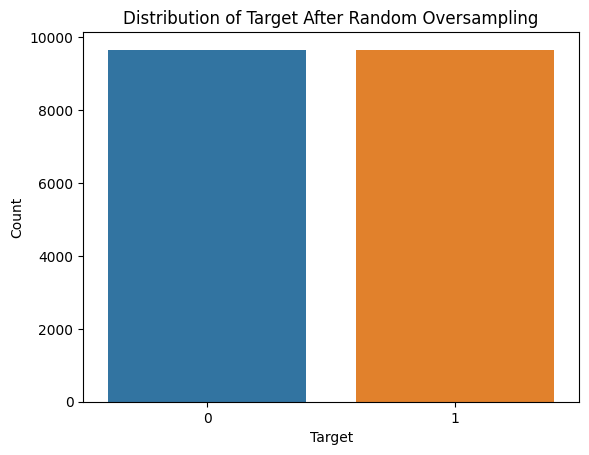

Target
0    9661
1    9661
Name: count, dtype: int64


In [54]:
# Apply Random 

# Concatenate the original dataset with the target variable
data_with_target = X.copy()
data_with_target['Target'] = y

# Separate the minority and majority classes
minority_class = data_with_target[data_with_target['Target'] == 1]
majority_class = data_with_target[data_with_target['Target'] == 0]

# Upsample the minority class
minority_upsampled = resample(minority_class, 
                               replace=True,     # Sample with replacement
                               n_samples=majority_class.shape[0],  # Match majority class size
                               random_state=42)

# Combine the upsampled minority class with the majority class
data_balanced = pd.concat([majority_class, minority_upsampled])

# Separate features and target again
X_balanced = data_balanced.drop(columns=['Target'])
y_balanced = data_balanced['Target']

# Check the new distribution of the target variable
sns.countplot(x=y_balanced)
plt.title('Distribution of Target After Random Oversampling')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Count the number of samples in each class after random oversampling
print(y_balanced.value_counts())

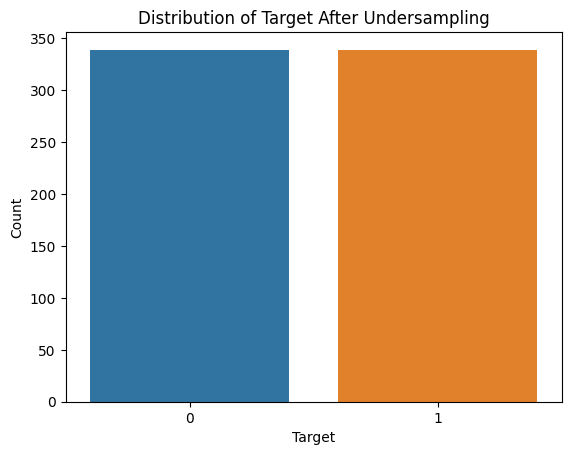

Target
0    339
1    339
Name: count, dtype: int64


In [55]:
# Apply Undersampling

# Undersample the majority class
majority_undersampled = resample(majority_class, 
                                 replace=False,     # No replacement, just reducing size
                                 n_samples=minority_class.shape[0],  # Match minority class size
                                 random_state=42)

# Combine the undersampled majority class with the minority class
data_undersampled = pd.concat([majority_undersampled, minority_class])

# Separate features and target again
X_undersampled = data_undersampled.drop(columns=['Target'])
y_undersampled = data_undersampled['Target']

# Check the new distribution of the target variable
sns.countplot(x=y_undersampled)
plt.title('Distribution of Target After Undersampling')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Count the number of samples in each class after undersampling
print(y_undersampled.value_counts())

### 4. Establish a Deep Neural network Architecture by using PyTorch library to handle the multi class classification task.    

In [56]:
# Check for any non-numeric values or NaN values
print(X_resampled.dtypes)  # Check data types of columns
print(X_resampled.isna().sum())  # Check for any missing values (NaN)

Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]     float64
Torque [Nm]                float64
Tool wear [min]            float64
dtype: object
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
dtype: int64


In [57]:
# Convert boolean columns to integers
X_resampled_encoded = X_resampled.astype(int)

# Check the data types again to ensure the conversion worked
print(X_resampled_encoded.dtypes)

Air temperature [K]        int64
Process temperature [K]    int64
Rotational speed [rpm]     int64
Torque [Nm]                int64
Tool wear [min]            int64
dtype: object


In [58]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_encoded, y_resampled, test_size=0.2, random_state=42)

In [59]:
# Convert cleaned and encoded training data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)  # Numeric data
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Target labels as long for classification

# Create a dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Ensure X_test is in the same format (cleaned and encoded)
X_test_encoded = X_test.astype(int)
X_test_tensor = torch.tensor(X_test_encoded.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Check data
print(X_train_tensor.shape, y_train_tensor.shape)
print(X_test_tensor.shape, y_test_tensor.shape)

torch.Size([15457, 5]) torch.Size([15457])
torch.Size([3865, 5]) torch.Size([3865])


In [60]:
# Define the neural network architecture
class DNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DNNModel, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # First hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Second hidden layer
        self.fc3 = nn.Linear(hidden_dim, output_dim)  # Output layer
        
        # Activation function (ReLU for hidden layers)
        self.relu = nn.ReLU()
        
        # Softmax activation for multi-class output
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply the first hidden layer and ReLU activation
        x = self.relu(self.fc2(x))  # Apply the second hidden layer and ReLU activation
        x = self.fc3(x)  # Output layer
        return x

In [61]:
# Model instantiation
input_dim = X_train_tensor.shape[1]  # Number of input features
hidden_dim = 128  # Number of neurons in the hidden layers
output_dim = len(y_train_tensor.unique())  # Number of classes (multi-class classification)

model = DNNModel(input_dim, hidden_dim, output_dim)
print(model)

DNNModel(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


In [62]:
# Loss function (CrossEntropyLoss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [63]:
# Define the number of epochs
epochs = 10

# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for i, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Print running loss
        running_loss += loss.item()
    
    # Print average loss after every epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/10, Loss: 0.35662367435033654
Epoch 2/10, Loss: 0.3021335476193546
Epoch 3/10, Loss: 0.29613741542682176
Epoch 4/10, Loss: 0.29232187353628725
Epoch 5/10, Loss: 0.2910488406427143
Epoch 6/10, Loss: 0.290730037718765
Epoch 7/10, Loss: 0.28819381895144125
Epoch 8/10, Loss: 0.2864432015325412
Epoch 9/10, Loss: 0.28802924129095947
Epoch 10/10, Loss: 0.2853480786208279


In [64]:
# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Forward pass on the test set
    outputs = model(X_test_tensor)
    
    # Get predictions by taking the class with the highest probability
    _, predicted = torch.max(outputs, 1)
    
    # Calculate accuracy
    correct = (predicted == y_test_tensor).sum().item()
    accuracy = correct / len(y_test_tensor)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 86.21%


In [65]:
# Initialize lists to store loss and accuracy
train_losses = []
train_accuracies = []

# Training loop (with metrics tracking)
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Store loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy*100:.2f}%")

Epoch [1/10], Loss: 0.2862, Accuracy: 86.77%
Epoch [2/10], Loss: 0.2853, Accuracy: 86.44%
Epoch [3/10], Loss: 0.2842, Accuracy: 86.59%
Epoch [4/10], Loss: 0.2836, Accuracy: 86.71%
Epoch [5/10], Loss: 0.2829, Accuracy: 86.65%
Epoch [6/10], Loss: 0.2821, Accuracy: 86.82%
Epoch [7/10], Loss: 0.2815, Accuracy: 86.82%
Epoch [8/10], Loss: 0.2808, Accuracy: 86.88%
Epoch [9/10], Loss: 0.2822, Accuracy: 86.79%
Epoch [10/10], Loss: 0.2820, Accuracy: 86.85%


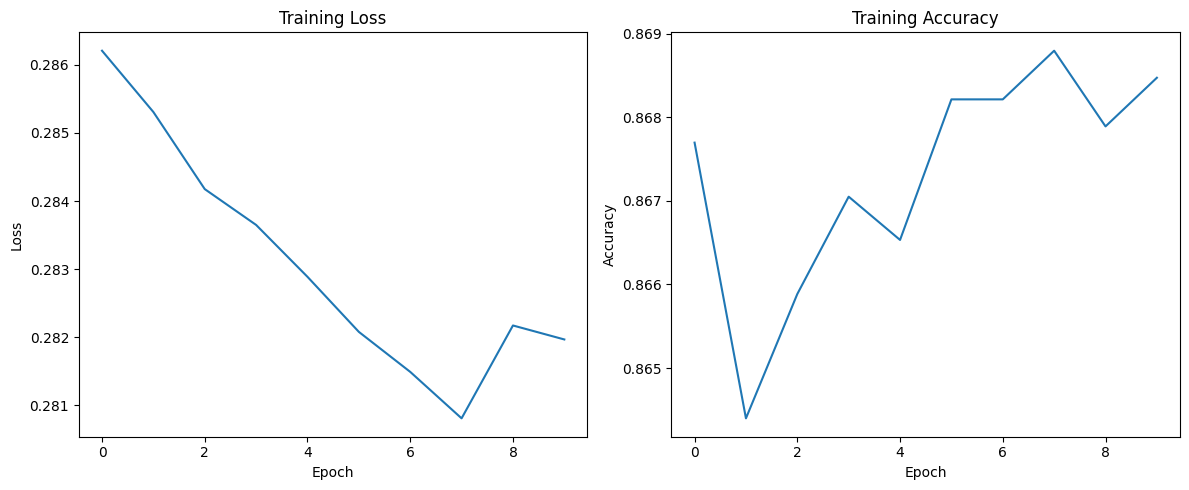

In [66]:
# Plot Training Loss and Accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

### 5. By using GridSearch tool from sklearn library chose the best hyper-parameters (learning rate, optimizers, epoch, model architecture, etc) that will give an efficient model.  

In [67]:
# Wrapping the PyTorch Model into a Scikit-learn Estimator
class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2, learning_rate=0.001, num_epochs=10, optimizer_type='adam'):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.optimizer_type = optimizer_type

        # Initialize model, criterion and optimizer
        self.model = DNNModel(self.input_dim, self.hidden_dim, self.output_dim)
        self.criterion = nn.CrossEntropyLoss()

        if self.optimizer_type == 'adam':
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        elif self.optimizer_type == 'sgd':
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.learning_rate)
        else:
            raise ValueError("Invalid optimizer type. Choose 'adam' or 'sgd'.")

    def fit(self, X, y):
        self.model.train()
        train_dataset = TensorDataset(torch.tensor(X.values, dtype=torch.float32), torch.tensor(y.values, dtype=torch.long))
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

        for epoch in range(self.num_epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X.values, dtype=torch.float32))
            _, predicted = torch.max(outputs, 1)
        return predicted.numpy()

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

In [81]:
# Initialize the PyTorch model
clf = PyTorchClassifier(input_dim=X_train.shape[1], hidden_dim=64, output_dim=2, learning_rate=0.001, num_epochs=10, optimizer_type='adam')

grid_search = GridSearchCV(clf, param_grid, cv=2, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/opt/conda/lib/python3.10/site-p

GridSearchCV(cv=2, estimator=PyTorchClassifier(input_dim=5), n_jobs=-1,
             param_grid={'hidden_dim': [64], 'learning_rate': [0.001],
                         'num_epochs': [10], 'optimizer_type': ['adam']},
             verbose=1)

[CV 1/3] END hidden_dim=64, learning_rate=0.001, num_epochs=10, optimizer_type=adam;, score=nan total time=   0.0s
[CV 2/3] END hidden_dim=64, learning_rate=0.001, num_epochs=10, optimizer_type=adam;, score=nan total time=   0.0s
[CV 3/3] END hidden_dim=64, learning_rate=0.001, num_epochs=10, optimizer_type=adam;, score=nan total time=   0.0s


In [82]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_accuracy = best_model.score(X_test, y_test)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

Best Hyperparameters: {'hidden_dim': 64, 'learning_rate': 0.001, 'num_epochs': 10, 'optimizer_type': 'adam'}
Test Set Accuracy: 0.8660


### 6. Visualize the two graph (Loss / Epochs) and (Accuracy / Epochs) for both training and test data 

In [84]:
# Convert the datasets to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders with batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [85]:
# Convert the datasets to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Epoch [1/20], Train Loss: 0.4843, Train Accuracy: 82.77%, Test Loss: 0.4483, Test Accuracy: 85.61%
Epoch [2/20], Train Loss: 0.4449, Train Accuracy: 85.76%, Test Loss: 0.4438, Test Accuracy: 85.43%
Epoch [3/20], Train Loss: 0.4422, Train Accuracy: 86.05%, Test Loss: 0.4437, Test Accuracy: 84.84%
Epoch [4/20], Train Loss: 0.4410, Train Accuracy: 86.10%, Test Loss: 0.4427, Test Accuracy: 85.92%
Epoch [5/20], Train Loss: 0.4399, Train Accuracy: 86.15%, Test Loss: 0.4420, Test Accuracy: 85.80%
Epoch [6/20], Train Loss: 0.4381, Train Accuracy: 86.34%, Test Loss: 0.4388, Test Accuracy: 86.11%
Epoch [7/20], Train Loss: 0.4378, Train Accuracy: 86.44%, Test Loss: 0.4385, Test Accuracy: 85.72%
Epoch [8/20], Train Loss: 0.4366, Train Accuracy: 86.57%, Test Loss: 0.4406, Test Accuracy: 86.39%
Epoch [9/20], Train Loss: 0.4375, Train Accuracy: 86.53%, Test Loss: 0.4362, Test Accuracy: 86.24%
Epoch [10/20], Train Loss: 0.4361, Train Accuracy: 86.50%, Test Loss: 0.4359, Test Accuracy: 86.31%
Epoch [11

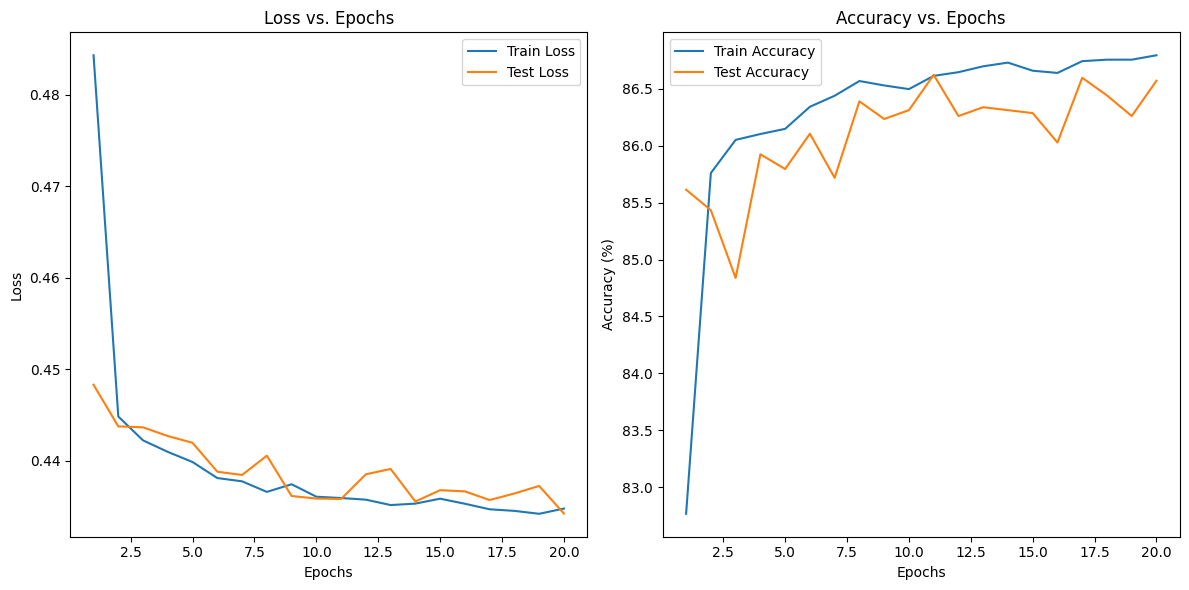

In [86]:
# Model Definition (SimpleNN class)
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

# Check if a GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, optimizer, and loss function
model = SimpleNN(input_dim=X_train_tensor.shape[1], output_dim=len(y_train_tensor.unique())).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

# Lists to store loss and accuracy for each epoch
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Train the model
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        # Accumulate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Compute average training loss and accuracy
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    # Evaluate the model on the test set
    model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    # Compute average test loss and accuracy
    avg_test_loss = running_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Plot the loss graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

# Plot the accuracy graph
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### 7. Calculate metrics like accuracy, sensitivity, f1 score, etc, on both training and test dataset.  

In [87]:
# Lists to store the metrics for each epoch
train_accuracies = []
test_accuracies = []
train_sensitivities = []
test_sensitivities = []
train_f1_scores = []
test_f1_scores = []

Epoch [1/20], Train Loss: 0.4343, Train Accuracy: 86.74%, Test Loss: 0.4364, Test Accuracy: 86.55%, Train Sensitivity: 0.87, Test Sensitivity: 0.87, Train F1 Score: 0.87, Test F1 Score: 0.87
Epoch [2/20], Train Loss: 0.4347, Train Accuracy: 86.74%, Test Loss: 0.4349, Test Accuracy: 86.57%, Train Sensitivity: 0.87, Test Sensitivity: 0.87, Train F1 Score: 0.87, Test F1 Score: 0.87
Epoch [3/20], Train Loss: 0.4346, Train Accuracy: 86.76%, Test Loss: 0.4357, Test Accuracy: 86.34%, Train Sensitivity: 0.87, Test Sensitivity: 0.86, Train F1 Score: 0.87, Test F1 Score: 0.86
Epoch [4/20], Train Loss: 0.4345, Train Accuracy: 86.73%, Test Loss: 0.4359, Test Accuracy: 86.57%, Train Sensitivity: 0.87, Test Sensitivity: 0.87, Train F1 Score: 0.87, Test F1 Score: 0.87
Epoch [5/20], Train Loss: 0.4337, Train Accuracy: 86.94%, Test Loss: 0.4367, Test Accuracy: 86.44%, Train Sensitivity: 0.87, Test Sensitivity: 0.86, Train F1 Score: 0.87, Test F1 Score: 0.86
Epoch [6/20], Train Loss: 0.4338, Train Accur

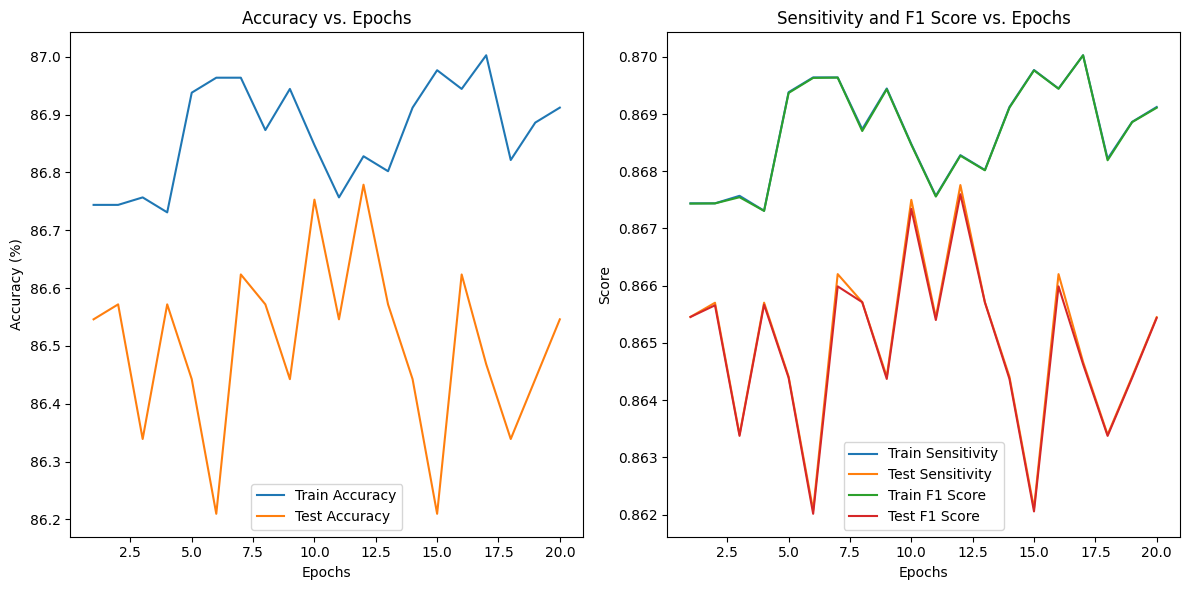

In [88]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_train_preds = []
    all_train_labels = []
    
    # Train the model
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        # Accumulate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # Store all predictions and true labels
        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())
    
    # Compute average training loss and accuracy
    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    # Calculate sensitivity (recall) and F1 score for training data
    train_sensitivity = recall_score(all_train_labels, all_train_preds, average='macro')  # macro averages for multi-class
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
    train_sensitivities.append(train_sensitivity)
    train_f1_scores.append(train_f1)

    # Evaluate the model on the test set
    model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0
    all_test_preds = []
    all_test_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
            # Store all predictions and true labels for test data
            all_test_preds.extend(predicted.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())
    
    # Compute average test loss and accuracy
    avg_test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)
    
    # Calculate sensitivity (recall) and F1 score for test data
    test_sensitivity = recall_score(all_test_labels, all_test_preds, average='macro')  # macro averaging for multi-class
    test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
    test_sensitivities.append(test_sensitivity)
    test_f1_scores.append(test_f1)

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, "
          f"Train Sensitivity: {train_sensitivity:.2f}, Test Sensitivity: {test_sensitivity:.2f}, "
          f"Train F1 Score: {train_f1:.2f}, Test F1 Score: {test_f1:.2f}")

# Optionally, you can visualize these metrics over epochs
plt.figure(figsize=(12, 6))

# Plot Accuracy vs Epochs
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epochs')
plt.legend()

# Plot Sensitivity (Recall) and F1 Score vs Epochs
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_sensitivities, label='Train Sensitivity')
plt.plot(range(1, num_epochs + 1), test_sensitivities, label='Test Sensitivity')
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), test_f1_scores, label='Test F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Sensitivity and F1 Score vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### 8. Apply several regularization techniques on your architecture then compare the obtained result with the first model.  

Epoch [1/20], Train Loss: 0.4462, Train Accuracy: 78.13%, Test Loss: 0.3360, Test Accuracy: 85.07%, Train Sensitivity: 0.78, Test Sensitivity: 0.85, Train F1 Score: 0.78, Test F1 Score: 0.85
Epoch [2/20], Train Loss: 0.3656, Train Accuracy: 83.24%, Test Loss: 0.3170, Test Accuracy: 85.43%, Train Sensitivity: 0.83, Test Sensitivity: 0.85, Train F1 Score: 0.83, Test F1 Score: 0.85
Epoch [3/20], Train Loss: 0.3460, Train Accuracy: 83.72%, Test Loss: 0.3078, Test Accuracy: 85.61%, Train Sensitivity: 0.84, Test Sensitivity: 0.86, Train F1 Score: 0.84, Test F1 Score: 0.86
Epoch [4/20], Train Loss: 0.3386, Train Accuracy: 84.38%, Test Loss: 0.3029, Test Accuracy: 85.92%, Train Sensitivity: 0.84, Test Sensitivity: 0.86, Train F1 Score: 0.84, Test F1 Score: 0.86
Epoch [5/20], Train Loss: 0.3372, Train Accuracy: 84.46%, Test Loss: 0.3008, Test Accuracy: 85.72%, Train Sensitivity: 0.84, Test Sensitivity: 0.86, Train F1 Score: 0.84, Test F1 Score: 0.86
Epoch [6/20], Train Loss: 0.3303, Train Accur

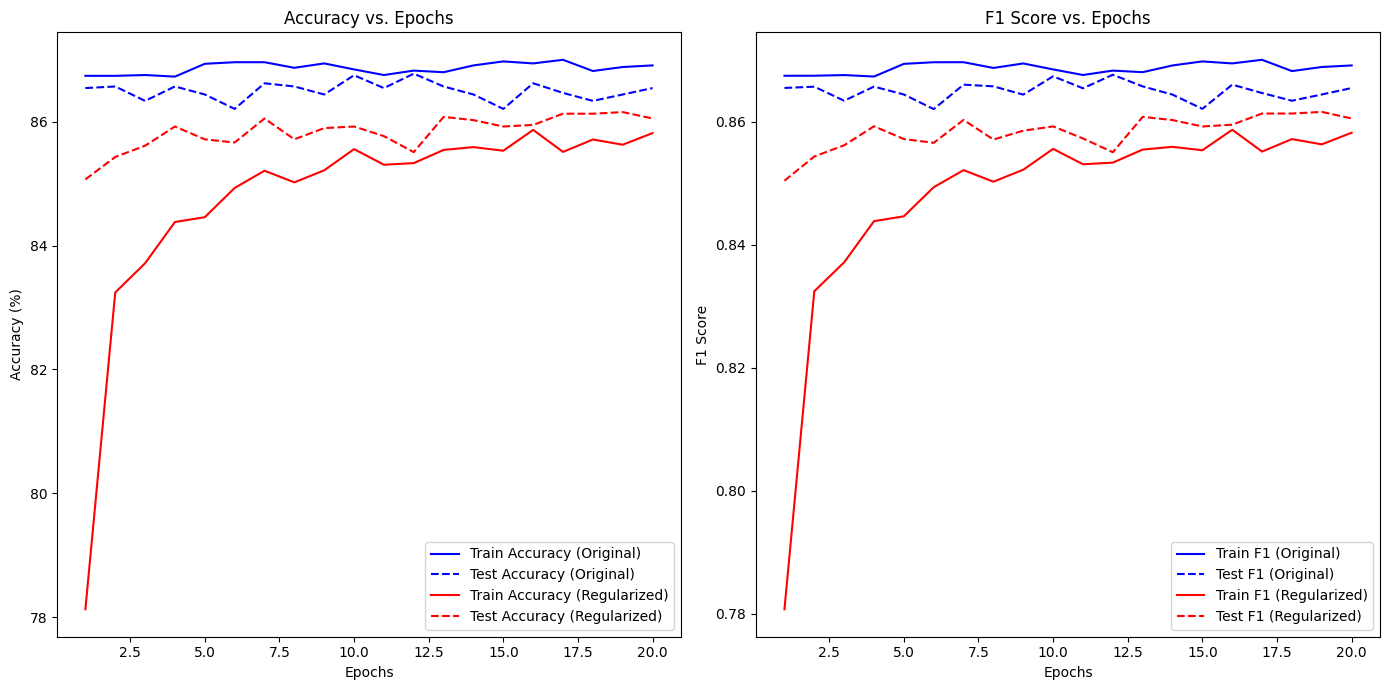

In [89]:
# Define a regularized version of the model with Dropout
class RegularizedNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RegularizedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(0.5)  # 50% dropout
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc3(x)
        return x

# Regularized Model Initialization
model_regularized = RegularizedNN(input_dim=X_train_tensor.shape[1], output_dim=len(y_train_tensor.unique())).to(device)

# Optimizer with L2 Regularization (Weight Decay)
optimizer_regularized = torch.optim.Adam(model_regularized.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization

# Cross-Entropy Loss
criterion = nn.CrossEntropyLoss()

# Lists to store the metrics for regularized model
train_accuracies_reg = []
test_accuracies_reg = []
train_sensitivities_reg = []
test_sensitivities_reg = []
train_f1_scores_reg = []
test_f1_scores_reg = []

# Training loop for the regularized model
num_epochs = 20
for epoch in range(num_epochs):
    model_regularized.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_train_preds = []
    all_train_labels = []
    
    # Train the regularized model
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer_regularized.zero_grad()
        outputs = model_regularized(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_regularized.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies_reg.append(train_accuracy)
    
    train_sensitivity = recall_score(all_train_labels, all_train_preds, average='macro')
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')
    train_sensitivities_reg.append(train_sensitivity)
    train_f1_scores_reg.append(train_f1)

    # Evaluate the regularized model on the test set
    model_regularized.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0
    all_test_preds = []
    all_test_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_regularized(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            all_test_preds.extend(predicted.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    avg_test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_accuracies_reg.append(test_accuracy)
    
    test_sensitivity = recall_score(all_test_labels, all_test_preds, average='macro')
    test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
    test_sensitivities_reg.append(test_sensitivity)
    test_f1_scores_reg.append(test_f1)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, "
          f"Train Sensitivity: {train_sensitivity:.2f}, Test Sensitivity: {test_sensitivity:.2f}, "
          f"Train F1 Score: {train_f1:.2f}, Test F1 Score: {test_f1:.2f}")

# Plot Accuracy and F1 Score comparison between original and regularized model
plt.figure(figsize=(14, 7))

# Accuracy comparison
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy (Original)', linestyle='-', color='blue')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy (Original)', linestyle='--', color='blue')
plt.plot(range(1, num_epochs + 1), train_accuracies_reg, label='Train Accuracy (Regularized)', linestyle='-', color='red')
plt.plot(range(1, num_epochs + 1), test_accuracies_reg, label='Test Accuracy (Regularized)', linestyle='--', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Epochs')
plt.legend()

# F1 Score comparison
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 (Original)', linestyle='-', color='blue')
plt.plot(range(1, num_epochs + 1), test_f1_scores, label='Test F1 (Original)', linestyle='--', color='blue')
plt.plot(range(1, num_epochs + 1), train_f1_scores_reg, label='Train F1 (Regularized)', linestyle='-', color='red')
plt.plot(range(1, num_epochs + 1), test_f1_scores_reg, label='Test F1 (Regularized)', linestyle='--', color='red')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Epochs')
plt.legend()

plt.tight_layout()
plt.show()